# P2

In [ ]:
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download paultimothymooney/chest-xray-pneumonia
! unzip -q 'chest-xray-pneumonia.zip'

In [ ]:
import numpy as np
import cv2
import os

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

from matplotlib import pyplot as plt

In [ ]:
base_directory = '/content/chest_xray/'
sub_directories = ['train/', 'val/', 'test/']
classes = os.listdir(
    os.path.join(base_directory, sub_directories[0])
)
print(classes)

['NORMAL', 'PNEUMONIA']


In [ ]:
X = []
y = []

for sub_dir in sub_directories:
    for c in range(len(classes)):
        dir = os.path.join(base_directory, sub_dir, classes[c])
        for f in os.listdir(dir):
            img = cv2.imread(os.path.join(dir, f))
            img = cv2.resize(img, (128, 128))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            X.append(img)
            y.append(c)


X = np.asarray(X)/255.0
y = np.asarray(y)

X.shape

(5856, 128, 128, 3)

In [ ]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)
train_index, test_index = next(splitter.split(X, y))

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
test_index, val_index = next(splitter.split(X_test, y_test))

X_test, X_val = X_test[test_index], X_test[val_index]
y_test, y_val = y_test[test_index], y_test[val_index]

In [ ]:
print(f'\t\t{classes[0]}\t\t{classes[1]}')
print(f'training:\t{np.count_nonzero(y_train==0)}\t\t{np.count_nonzero(y_train==1)}')
print(f'validation:\t{np.count_nonzero(y_val==0)}\t\t{np.count_nonzero(y_val==1)}')
print(f'testing:\t{np.count_nonzero(y_test==0)}\t\t{np.count_nonzero(y_test==1)}')

		NORMAL		PNEUMONIA
training:	950		2563
validation:	317		855
testing:	316		855


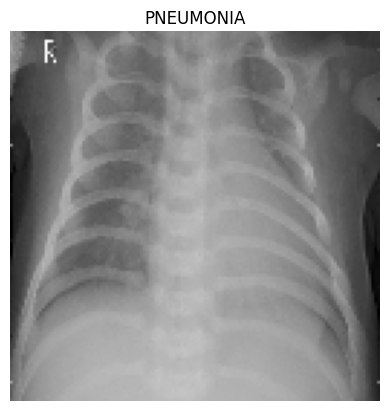

In [ ]:
plt.imshow(X_train[0])
plt.title(classes[y_train[0]])
plt.axis("Off");
plt.show()

In [ ]:
generator = ImageDataGenerator(
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=30,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='constant',
    cval=0.0
)

batch_size = 32
steps_per_epoch = X_train.shape[0] // batch_size

data_iterator = generator.flow(X_train, y_train, batch_size=batch_size)

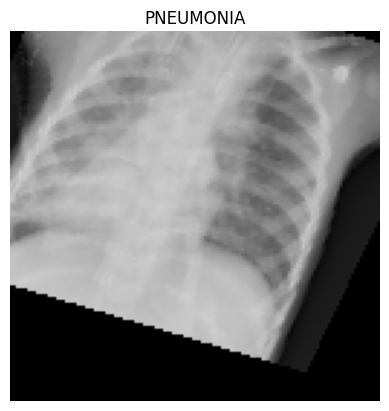

In [ ]:
img, label = generator.flow(X_train, y_train, batch_size=1).next()

plt.imshow(img[0])
plt.title(classes[label[0]])
plt.axis("Off");
plt.show()

In [ ]:
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weight = {
    0: class_weights[0],
    1: class_weights[1]
}

In [ ]:
# from keras.callbacks import ModelCheckpoint, EarlyStopping

# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     verbose=1,
#     restore_best_weights=True
# )

# checkpoints = ModelCheckpoint(
#     'tmp/checkpoint',
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=1
# )

In [ ]:
input_layer = keras.layers.Input(shape=(128, 128, 3))
efficientNet = keras.applications.EfficientNetB2(
    include_top=False, weights="imagenet", input_shape=(128, 128, 3))

# efficientNet.trainable = False

x = efficientNet(input_layer, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(input_layer, output_layer)

In [ ]:
for layer in efficientNet.layers[:74]:
    layer.trainable = False

lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    [10*steps_per_epoch, 15*steps_per_epoch],
    [0.00001, 0.000005, 0.000001]
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

history = model.fit(
    data_iterator, epochs = 20, class_weight = class_weight,
    steps_per_epoch = steps_per_epoch,
    validation_data = (X_val, y_val)
    # callbacks = [early_stopping, checkpoints]
)

Epoch 1/20
109/109 [==============================] - 88s 230ms/step - loss: 0.6971 - accuracy: 0.5208 - val_loss: 0.7064 - val_accuracy: 0.2765
Epoch 2/20
109/109 [==============================] - 19s 174ms/step - loss: 0.6880 - accuracy: 0.5375 - val_loss: 0.6871 - val_accuracy: 0.5418
Epoch 3/20
109/109 [==============================] - 18s 166ms/step - loss: 0.6852 - accuracy: 0.5757 - val_loss: 0.6135 - val_accuracy: 0.7696
Epoch 4/20
109/109 [==============================] - 19s 168ms/step - loss: 0.6804 - accuracy: 0.5797 - val_loss: 0.6230 - val_accuracy: 0.7312
Epoch 5/20
109/109 [==============================] - 18s 168ms/step - loss: 0.6772 - accuracy: 0.6036 - val_loss: 0.6549 - val_accuracy: 0.6877
Epoch 6/20
109/109 [==============================] - 19s 169ms/step - loss: 0.6727 - accuracy: 0.5777 - val_loss: 0.5967 - val_accuracy: 0.7739
Epoch 7/20
109/109 [==============================] - 19s 171ms/step - loss: 0.6311 - accuracy: 0.6119 - val_loss: 0.5374 - val_ac

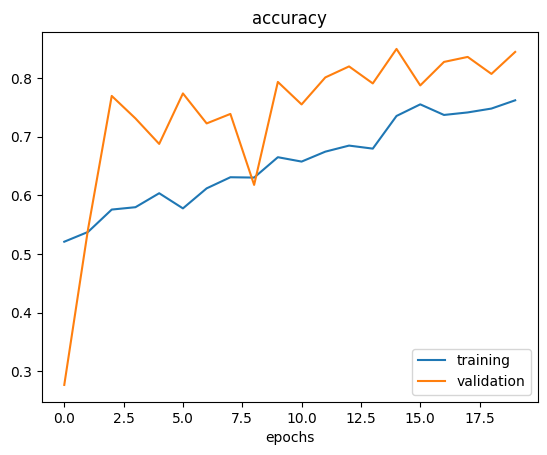

In [ ]:
plt.plot(history.history['accuracy'], label="training")
plt.plot(history.history['val_accuracy'], label="validation")
plt.title('accuracy')
plt.xlabel("epochs")
plt.legend(loc='lower right')
plt.show()

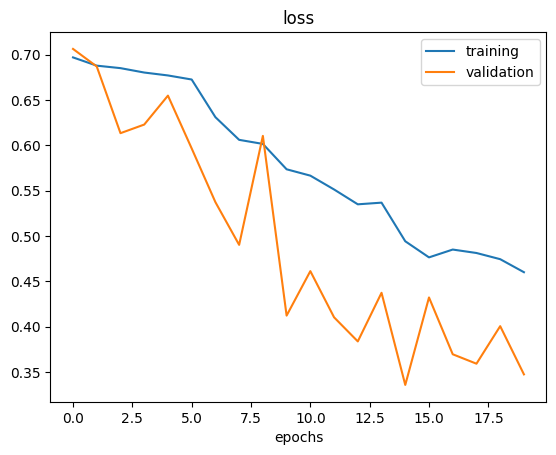

In [ ]:
plt.plot(history.history['loss'], label="training")
plt.plot(history.history['val_loss'], label="validation")
plt.title('loss')
plt.xlabel("epochs")
plt.legend()
plt.show()

In [ ]:
probas = model.predict(X_test)
y_pred = np.asarray(0.5 < probas, dtype=np.int32)

37/37 [==============================] - 1s 32ms/step


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.88      0.73       316
           1       0.95      0.80      0.87       855

    accuracy                           0.82      1171
   macro avg       0.78      0.84      0.80      1171
weighted avg       0.86      0.82      0.83      1171



In [ ]:
def draw_confusion_matrix(matrix):
    green = (30, 200, 40, 160)
    red = (255, 25, 0, 140)

    x = matrix.shape[1]
    y = matrix.shape[0]

    colors = [[green if i==j else red for i in range(x)] for j in range(y)]
    colors = np.array(colors).astype(np.uint8)

    fig, ax = plt.subplots(figsize=(4, 4), dpi=90)
    ax.imshow(colors)

    ax.set_xticks(np.arange(x), labels=range(x))
    ax.set_yticks(np.arange(y), labels=range(y))
    
    ax.set_xticks(np.arange(-.5, x, 1), minor=True)
    ax.set_yticks(np.arange(-.5, y, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax.tick_params(which='minor', bottom=False, left=False)

    ax.set_xlabel("prediction")
    ax.set_ylabel("label")

    for i in range(y):
        for j in range(x):
            text = ax.text(j, i, matrix[i][j], ha="center", va="center", color='black')

    ax.set_title("Confusion Matrix")
    fig.tight_layout()
    plt.show()

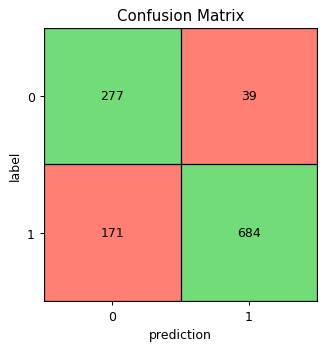

In [ ]:
draw_confusion_matrix(
    confusion_matrix(y_test, y_pred)
)

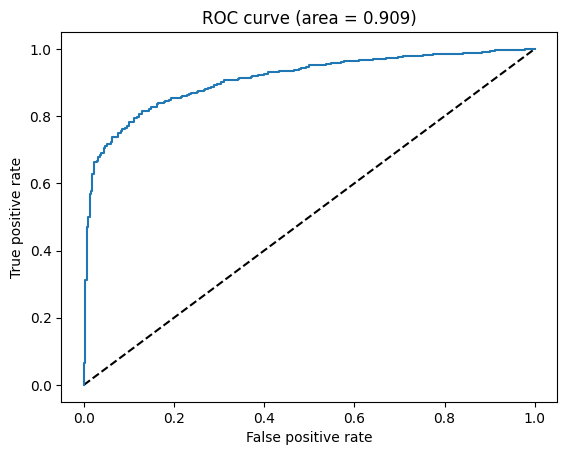

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, probas.ravel())
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
area_under_curve = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (area = {:.3f})'.format(area_under_curve))
plt.show()